In [2]:
from pathlib import Path
from omnibelt import toposort, load_json, save_json
from itertools import product, combinations
# import pyperclip
import random
import json
from PIL import Image
from graphviz import Digraph
import matplotlib.pyplot as plt
import io
# import clipboard
import networkx as nx
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
from omniply import tool, ToolKit, Context

import numpy as np
import torch
from causalbenchmark.novo.simulation.models import Bernoulli, ConditionalBernoulli, BernoulliNetwork
from causalbenchmark.novo.seeding import NewsHeadlines, StatisticsPrompting, Story
# from causalbenchmark.novo.seeding.prompting import GraphInfo
from causalbenchmark.novo.templating import FixedTemplate, SimpleTemplater, FileTemplate
from causalbenchmark.novo import misc

In [3]:
spark_generator = NewsHeadlines(locs=['gb', 'de', 'fr', 'it', 'nl'], 
                                # dataset_root=Path(r'/home/fleeb/workspace/local_data/nnn/babel-briefings-v1'),
                                # dataset_root=Path(r'C:\Users\anwan\Documents\workspace\nnn\babel-briefings-v1'),
                                dataset_root=Path(r'C:\Users\anwan\workspace\local_data\nnn\babel-briefings-v1'),
                                ).load(pbar=tqdm)
len(spark_generator.article_IDs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [43]:
# ctx = Story(story_root=misc.data_root() / 'stories', story_id='test17')
ctx = Story(story_root=misc.data_root() / 'stories').populate_defaults()
ctx.include(spark_generator,)
# print(ctx)
# ctx['seed'] = 6660483#2494534#91220#1684065#6805333
# ctx['seed'] = 3506717#3357669#6660483
# ctx['spark'] = '''Title: Naples, Apple renews the Academy program with the Federico II University - Rai News
# Description: The academic training born between Cupertino and the University in 2016 restarts at the San Giovanni a Teduccio headquarters
# Original Language: Italian'''
print(ctx['seed'])
print(ctx['spark'])

1997993
Title: The Wheel: Michael McIntyre’s gameshow infuriates BBC viewers 'Too confusing!' - Daily Express
Description: MICHAEL MCINTYRE'S brand-new gameshow The Wheel kicked off on BBC One this evening - but some viewers had trouble getting their heads around the rules of the latest prime-time show.
Original Language: English


In [26]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
print(ctx['prompt_motivation'])

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Follow the opening stage of the Tour of Britain 2021 - Cycling Flash here
Description: Many riders use the Benelux Tour as the last multi-day event in their preparation for the World Championships in Leuven at the end of September. However, there are also a number of people who want to dot their i's and cross their i's in the Tour of Britain. Today is the opening stage between…
Original Language: Dutch
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be perf

In [28]:
##############################################
motivation_raw = '''

{
  "introduction": "With the Tour of Britain 2021 igniting excitement among cycling enthusiasts, it's interesting to delve into the performance trends of riders who participate in both the Benelux Tour and the Tour of Britain. By comparing their finishing times, average speeds, and stage rankings in these events, we can uncover insights into how the rigors of the Benelux Tour impact their subsequent performance in the Tour of Britain. This exploration could reveal whether participating in the Benelux Tour serves as an effective warm-up for riders or if it leads to fatigue that affects their performance in Britain.",
  "title": "Impact_of_Benelux_Tour_on_Tour_of_Britain_Performance"
}






'''
##############################################
ctx['motivation'] = json.loads(motivation_raw)

In [29]:
# if 'prompt_graph' in ctx:
#     del ctx['prompt_graph']
# print(FileTemplate('graph').fill_in(ctx))
print(ctx['prompt_graph'])

We are interested in building a causal model based on the explicit and implicit assumptions contained in the specified article and then using causal inference to evaluate the reasoning. Answer the following questions to design an interesting, simple, and most importantly realistic causal model from a news article.

To help understand the instructions here are some tips:
- all variables are always binary and (at least in principle) measurable, so when creating and selecting variables, make sure it is reasonable to treat them as binary
- whenever you propose a variable, make sure to define the meaning of each value it can take, and mention whether it is observable or not
- outcome variables are always observable, and should always have 2-3 causal parents (including treatment, mediator, and confounder variables)
- treatment variables are always observable and intervenable, that means it must be possible to (at least in principle) change their value if desired, and these should generally h

In [30]:
# nodes = ctx['nodes']
#################################################
nodes_raw = '''


[
  {
    "name": "Performance in Tour of Britain",
    "description": "The overall performance of a rider in the Tour of Britain.",
    "type": "outcome",
    "observed": true,
    "values": ["Below Average", "Above Average"],
    "parents": ["Participation in Benelux Tour", "Fatigue Level"]
  },
  {
    "name": "Participation in Benelux Tour",
    "description": "Whether a rider participates in the Benelux Tour before the Tour of Britain.",
    "type": "treatment",
    "observed": true,
    "values": ["No Participation", "Participation"],
    "parents": ["Physical Fitness Level", "Experience in Professional Cycling"]
  },
  {
    "name": "Physical Fitness Level",
    "description": "The physical fitness level of a rider.",
    "type": "treatment",
    "observed": true,
    "values": ["Low Fitness", "High Fitness"],
    "parents": ["Experience in Professional Cycling"]
  },
  {
    "name": "Experience in Professional Cycling",
    "description": "The rider's experience level in professional cycling.",
    "type": "confounder",
    "observed": true,
    "values": ["Less Experienced", "Highly Experienced"],
    "parents": []
  },
  {
    "name": "Weather Conditions",
    "description": "The weather conditions during the races.",
    "type": "confounder",
    "observed": true,
    "values": ["Adverse Weather", "Favorable Weather"],
    "parents": []
  },
  {
    "name": "Fatigue Level",
    "description": "The level of fatigue a rider experiences.",
    "type": "mediator",
    "observed": true,
    "values": ["Low Fatigue", "High Fatigue"],
    "parents": ["Participation in Benelux Tour", "Training Intensity"]
  },
  {
    "name": "Training Intensity",
    "description": "The intensity of training undertaken by the rider.",
    "type": "mediator",
    "observed": false,
    "values": ["Low Intensity", "High Intensity"],
    "parents": ["Physical Fitness Level", "Weather Conditions"]
  },
  {
    "name": "Public Perception of Performance",
    "description": "The public's perception of a rider's performance.",
    "type": "collider",
    "observed": true,
    "values": ["Negative Perception", "Positive Perception"],
    "parents": ["Performance in Tour of Britain", "Weather Conditions"]
  }
]





'''
#################################################
if len(nodes_raw):
    nodes = json.loads(nodes_raw)
varparents = {node['name']: node['parents'] for node in nodes}
varorder = toposort(varparents)
nodes = sorted(nodes, key=lambda x: varorder.index(x['name']))
nodes = [node for node in nodes if len(node['parents']) or any(node['name'] in parent for parent in varparents.values())]
ctx['nodes'] = nodes

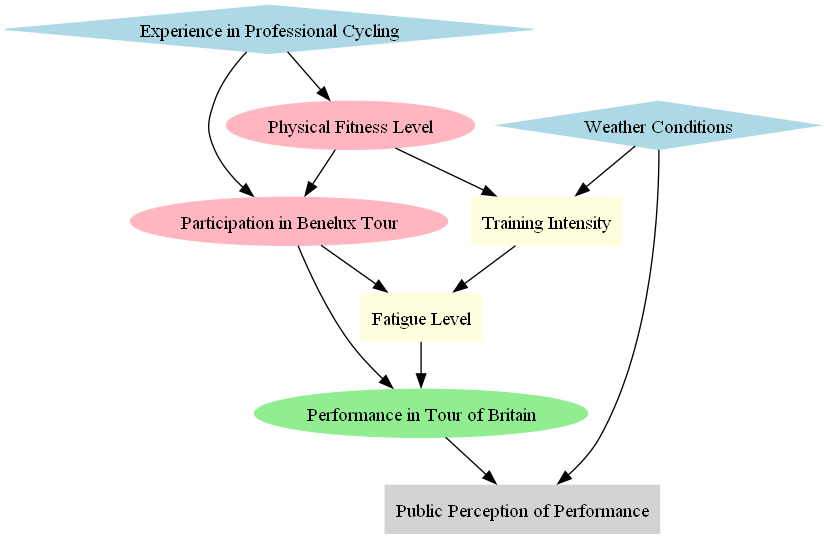

In [31]:
dot = Digraph(comment='Causal Model')
node_styles = {
    "treatment": {"shape": "ellipse", "style": "filled", "color": "lightpink"},
    "outcome": {"shape": "ellipse", "style": "filled", "color": "lightgreen"},
    "confounder": {"shape": "diamond", "style": "filled", "color": "lightblue"},
    "mediator": {"shape": "box", "style": "filled", "color": "lightyellow"},
    "collider": {"shape": "box", "style": "filled", "color": "lightgray"}
}
for node in ctx['nodes']:
    style = node_styles.get(node["type"], {"shape": "ellipse"})
    dot.node(node["name"], node["name"], **style)
for node in ctx['nodes']:
    for parent in node["parents"]:
        dot.edge(parent, node["name"])
# dot.view()
dot.render(str(misc.temp_root() / 'graph'), format='png')
Image.open(misc.temp_root() / 'graph.png')

In [32]:
# if 'prompt_story' in ctx:
#     del ctx['prompt_motivation']
# print(FileTemplate('structure').fill_in(ctx))
print(ctx['prompt_structure'])


We have a causal bayes net model for an analysis about this topic:

With the Tour of Britain 2021 igniting excitement among cycling enthusiasts, it's interesting to delve into the performance trends of riders who participate in both the Benelux Tour and the Tour of Britain. By comparing their finishing times, average speeds, and stage rankings in these events, we can uncover insights into how the rigors of the Benelux Tour impact their subsequent performance in the Tour of Britain. This exploration could reveal whether participating in the Benelux Tour serves as an effective warm-up for riders or if it leads to fatigue that affects their performance in Britain.

Write a list of 4-8 concise and well-worded sentences that describe the structure and associated assumptions of the causal graph. The sentences should be ordered from describing the most noteworthy/surprising features of the graph to the most natural/intuitive features. Use an intuitive conversational style to describe the cau

In [33]:
#################################################

structure_raw = '''



[
  {"sentence": "Interestingly, how the public perceives a rider's performance is influenced not just by their actual performance in the Tour of Britain, but also by the weather conditions during the race, suggesting that external factors can significantly shape public opinion.", "involved": ["Public Perception of Performance", "Performance in Tour of Britain", "Weather Conditions"]},
  {"sentence": "A rider's decision to participate in the Benelux Tour before the Tour of Britain is shaped by both their physical fitness and their experience in professional cycling, indicating that both inherent ability and past experience play roles in making strategic choices.", "involved": ["Participation in Benelux Tour", "Physical Fitness Level", "Experience in Professional Cycling"]},
  {"sentence": "The intensity of training a rider undertakes is determined by their physical fitness and the weather conditions, highlighting how both personal capability and environmental factors interact to influence preparation strategies.", "involved": ["Training Intensity", "Physical Fitness Level", "Weather Conditions"]},
  {"sentence": "A rider's level of fatigue, which is a crucial factor affecting their performance in the Tour of Britain, is impacted by their participation in the Benelux Tour and how intensely they train, showing the direct consequences of their preparatory decisions.", "involved": ["Fatigue Level", "Participation in Benelux Tour", "Training Intensity"]},
  {"sentence": "The overall performance of a rider in the Tour of Britain is directly influenced by their fatigue level and their participation in the Benelux Tour, suggesting that both immediate physical condition and prior race experiences are key to success.", "involved": ["Performance in Tour of Britain", "Fatigue Level", "Participation in Benelux Tour"]},
  {"sentence": "A rider's physical fitness is not only crucial for their performance but also plays a role in determining their training intensity and decision to participate in previous tours, indicating that fitness is a foundational aspect in a cyclist's career.", "involved": ["Physical Fitness Level", "Training Intensity", "Participation in Benelux Tour"]},
  {"sentence": "Experience in professional cycling is a fundamental factor that influences a rider's physical fitness and their decision to participate in the Benelux Tour, pointing to the importance of accumulated experience in shaping a rider's career trajectory.", "involved": ["Experience in Professional Cycling", "Physical Fitness Level", "Participation in Benelux Tour"]},
  {"sentence": "Weather conditions not only affect the rider's training intensity but also play a role in shaping the public's perception of their performance, illustrating how environmental factors can have a broad impact on both preparation and perception.", "involved": ["Weather Conditions", "Training Intensity", "Public Perception of Performance"]}
]





'''

#################################################
ctx['structure'] = json.loads(structure_raw)

In [34]:
# if 'prompt_stats' in ctx:
#     del ctx['descriptions']
#     del ctx['prob_questions']
#     del ctx['prompt_stats']
# print(FileTemplate('stats').fill_in(ctx))
print(ctx['prompt_stats'])

We have a causal bayes net based on the following topic:

With the Tour of Britain 2021 igniting excitement among cycling enthusiasts, it's interesting to delve into the performance trends of riders who participate in both the Benelux Tour and the Tour of Britain. By comparing their finishing times, average speeds, and stage rankings in these events, we can uncover insights into how the rigors of the Benelux Tour impact their subsequent performance in the Tour of Britain. This exploration could reveal whether participating in the Benelux Tour serves as an effective warm-up for riders or if it leads to fatigue that affects their performance in Britain.

Now we would like to estimate the probabilities of certain events in a corresponding causal bayes net.

Using commonsense, estimate the probabilities of the following events:

1. what is the probability that "Experience in Professional Cycling" is "Highly Experienced" (rather than "Less Experienced")?
2. when "Experience in Professional 

In [35]:
# probabilities = ctx['stats']
#################################################

probabilities_raw = '''


{
  "1": [0.6, 0.7],
  "2": [0.3, 0.4],
  "3": [0.7, 0.8],
  "4": [0.2, 0.3],
  "5": [0.5, 0.6],
  "6": [0.6, 0.7],
  "7": [0.8, 0.9],
  "8": [0.5, 0.6],
  "9": [0.3, 0.4],
  "10": [0.4, 0.5],
  "11": [0.6, 0.7],
  "12": [0.7, 0.8],
  "13": [0.4, 0.5],
  "14": [0.2, 0.3],
  "15": [0.6, 0.7],
  "16": [0.4, 0.5],
  "17": [0.7, 0.8],
  "18": [0.3, 0.4],
  "19": [0.8, 0.9],
  "20": [0.5, 0.6],
  "21": [0.2, 0.3],
  "22": [0.3, 0.4],
  "23": [0.7, 0.8],
  "24": [0.8, 0.9]
}





'''

#################################################
ctx['stats'] = json.loads(probabilities_raw)

In [36]:
raw_prob_samples = []
def to_prob_range(raw):
    raw = [prange for _, prange in sorted(raw.items(), key=lambda item: int(item[0]))]
    return torch.tensor(raw)

prob_ranges = to_prob_range(ctx['stats'])
lower_bound, upper_bound = prob_ranges.t()

variables = {}
for node in ctx['nodes']:
    if len(node['parents']):
        variables[node['name']] = ConditionalBernoulli([variables[parent] for parent in node['parents']])
    else:
        variables[node['name']] = Bernoulli(0.5)
net = BernoulliNetwork(variables)
def mc_samples(N, *fns):
    estimates = []
    for _ in tqdm(range(N)):
        param_sample = torch.rand(len(prob_ranges), 1) * (upper_bound - lower_bound) + lower_bound
        net.set_params(param_sample)
        estimates.append([fn() for fn in fns])
    return torch.tensor(estimates)
def make_ate_fn(treatment, outcome, conditions=None):
    def ate_fn():
        return net.ate(treatment, conditions=conditions)[outcome].item()
    return ate_fn
def make_corr_fn(v1, v2):
    def corr_fn():
        return net.correlation(v1, v2).item()
    return corr_fn
treatment1, treatment2 = [n for n in ctx['treatments']]
# t1vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment1][0]
# t2vals = [node['values'] for node in ctx['nodes'] if node['name'] == treatment2][0]
outcome = ctx['outcome']#['name']
# ovals = [node['values'] for node in ctx['nodes'] if node['name'] == outcome][0]
confounders = [node for node in ctx['confounders']]

print(tabulate([
    [treatment1['name'], *treatment1['values'], treatment1['description']],
    [treatment2['name'], *treatment2['values'], treatment2['description']],
    [outcome['name'], *outcome['values'], outcome['description']],
]))

cate_keys = [(treatment, confounder, cval) for treatment in ctx['treatments'] for confounder in ctx['confounders'] for cval in [0, 1]]
cate_fns = [make_ate_fn(treatment['name'], outcome['name'], conditions={confounder['name']: val}) for treatment, confounder, val in cate_keys]
ate1, ate2, corr1, corr2, *cates = mc_samples(20, make_ate_fn(treatment1['name'], outcome['name']), make_ate_fn(treatment2['name'], outcome['name']),
                                      make_corr_fn(treatment1['name'], outcome['name']), make_corr_fn(treatment2['name'], outcome['name']), *cate_fns).t()

print('\n'.join(f'{node["name"]!r} means {node["description"]}' for node in ctx['nodes']))
print(tabulate([
    [f'{treatment1["values"][1]}', f'{treatment1["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate1.mean(), corr1.mean(), ],
    [f'{treatment2["values"][1]}', f'{treatment2["name"]}', f'{outcome["values"][1]}', f'{outcome["name"]}', ate2.mean(), corr2.mean(), ],
], headers=['Treatment Value', 'Treatment', 'Outcome Value', 'Outcome', 'ATE', 'Correlation']))

------------------------------  ----------------  -------------  ----------------------------------------------------------------------------
Physical Fitness Level          Low Fitness       High Fitness   The physical fitness level of a rider.
Participation in Benelux Tour   No Participation  Participation  Whether a rider participates in the Benelux Tour before the Tour of Britain.
Performance in Tour of Britain  Below Average     Above Average  The overall performance of a rider in the Tour of Britain.
------------------------------  ----------------  -------------  ----------------------------------------------------------------------------


  0%|          | 0/20 [00:00<?, ?it/s]

'Experience in Professional Cycling' means The rider's experience level in professional cycling.
'Physical Fitness Level' means The physical fitness level of a rider.
'Participation in Benelux Tour' means Whether a rider participates in the Benelux Tour before the Tour of Britain.
'Weather Conditions' means The weather conditions during the races.
'Training Intensity' means The intensity of training undertaken by the rider.
'Fatigue Level' means The level of fatigue a rider experiences.
'Performance in Tour of Britain' means The overall performance of a rider in the Tour of Britain.
'Public Perception of Performance' means The public's perception of a rider's performance.
Treatment Value    Treatment                      Outcome Value    Outcome                               ATE    Correlation
-----------------  -----------------------------  ---------------  ------------------------------  ---------  -------------
High Fitness       Physical Fitness Level         Above Average    Perf

C:\Users\anwan\miniconda3\Lib\site-packages\torch\masked\maskedtensor\core.py:156: UserWarning: The PyTorch API of MaskedTensors is in prototype stage and will change in the near future. Please open a Github issue for features requests and see our documentation on the torch.masked module for further information about the project.
  warnings.warn(("The PyTorch API of MaskedTensors is in prototype stage "
ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Treatment                                                ATE    Correlation  Outcome
-----------------------------------------------------  -----  -------------  -----------------------------------------------------
Highly Experienced Experience in Professional Cycling   0.4            0.21  High Fitness Physical Fitness Level
Highly Experienced Experience in Professional Cycling   0.39          -0.16  Participation Participation in Benelux Tour
Highly Experienced Experience in Professional Cycling   0              0     Favorable Weather Weather Conditions
Highly Experienced Experience in Professional Cycling   0.12           0.05  High Intensity Training Intensity
Highly Experienced Experience in Professional Cycling   0.05           0.07  High Fatigue Fatigue Level
Highly Experienced Experience in Professional Cycling   0.04          -0.01  Above Average Performance in Tour of Britain
Highly Experienced Experience in Professional Cycling   0.02          -0     Positive Perception Pu

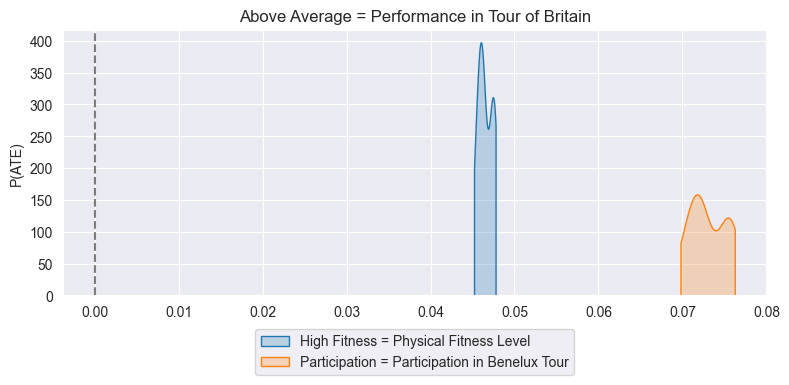

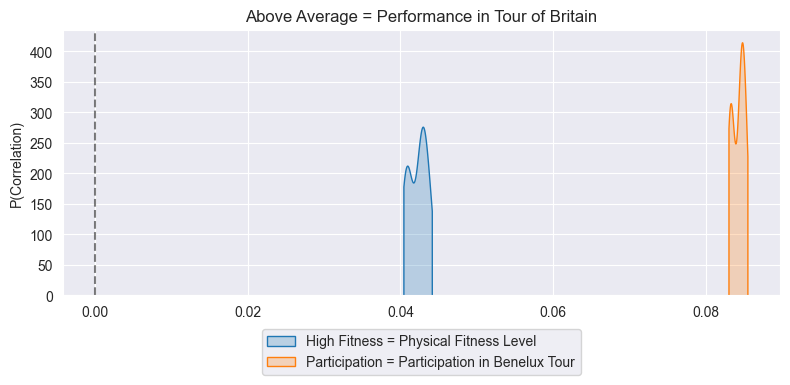

In [37]:
plt.figure(figsize=(8, 4))
sns.kdeplot(ate1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(ate1), max(ate1)));
sns.kdeplot(ate2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(ate2), max(ate2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(ATE)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

plt.figure(figsize=(8, 4))
sns.kdeplot(corr1, label=f'{treatment1["values"][1]} = {treatment1["name"]}', fill=True, clip=(min(corr1), max(corr1)));
sns.kdeplot(corr2, label=f'{treatment2["values"][1]} = {treatment2["name"]}', fill=True, clip=(min(corr2), max(corr2)));
plt.title(f'{outcome["values"][1]} = {outcome["name"]}')
plt.ylabel(f'P(Correlation)')
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.1))
plt.axvline(0, color='black', linestyle='--', alpha=0.5)
# plt.xlim(-1, 1)
plt.tight_layout();

mn1, mx1 = ate1.min().item(), ate1.max().item()
mu1 = ate1.mean().item()
assert mn1 * mx1 > 0, f'{mn1} * {mx1} < 0'
mn2, mx2 = ate2.min().item(), ate2.max().item()
mu2 = ate2.mean().item()
assert mn2 * mx2 > 0, f'{mn2} * {mx2} < 0'
ctx['ate1'] = ate1.mean().item()
ctx['ate2'] = ate2.mean().item()
reverse1 = mu1 < 0
reverse2 = mu2 < 0
# print(tabulate([(node['name'], *node['values'], node['description']) for node in ctx['nodes']], headers=['Variable Name', 'Value 0', 'Value 1', 'Description']))
# outcome = [node['name'] for node in ctx['nodes'] if node['type'] == 'outcome'][0]
tbl = []

for node1, node2 in product(ctx['nodes'], ctx['nodes']):
    if node1 != node2:
        tbl.append([
                    f'{node1["values"][1]} {node1["name"]}', 
                    f"{net.ate(node1['name'])[node2['name']].item():.2f}", 
                    f"{net.correlation(node1['name'], node2['name']).item():.2f}",
                    f'{node2["values"][1]} {node2["name"]}', 
                    # node1['description'], 
                    # node2['description'], 
                    ])
print(tabulate(tbl, headers=['Treatment', 'ATE', 'Correlation', 'Outcome', 
                             # 'Treatment Description', 'Outcome Description'
                             ]))

print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

In [38]:
# if 'prompt_verbs' in ctx:
#     del ctx['prompt_verbs']
print(FileTemplate('verbs').fill_in(ctx))
# print(ctx['prompt_verbs'])

We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a newspaper article or casual conversation, while still being semantically equivalent to the variable and value definition.

Here are the templates that we use to verbalize the variables:

1. One of the variables is {descriptor}.
2. {subject} [often/usually/sometimes/rarely/etc.] {predicate#}. (with pronoun: {pronoun})
3. There is a [number]% chance that {nounclause#}.
4. {preposition} [number]% of {domain}, {subclause#}.
5. Conditional sentence: {condition#}, [some consequence].
6. Interventional: If {action#}, [some effect].

Variable 'Experience in Professional Cycling' (0='Less Experienced', 1='Highly Experienced') means The rider's experience level in professional cycling.
Variable 'Physical Fitness Level' (0='Low Fitness', 1='High Fitness') means The physical fi

In [39]:
# verbalization = ctx['verbs']
#################################################
verbalization_raw = '''


{
  "Experience in Professional Cycling": {
    "descriptor": ["the rider's cycling experience", "the cyclist's track record"],
    "subject": "the rider",
    "predicate0": ["is relatively new to professional cycling", "has less experience in professional tours"],
    "predicate1": ["is a veteran in professional cycling", "boasts extensive professional cycling experience"],
    "pronoun": "they",
    "nounclause0": ["the rider is new to professional cycling", "the cyclist has limited experience in professional tours"],
    "nounclause1": ["the rider is seasoned in professional cycling", "the cyclist has a wealth of experience in professional tours"],
    "preposition": ["among", "in the case of"],
    "domain": "cyclists",
    "subclause0": ["a cyclist is new to the professional scene", "there is limited experience in professional cycling"],
    "subclause1": ["a cyclist is seasoned in professional tours", "there is extensive experience in professional cycling"],
    "condition0": ["if the cyclist is newer to the professional scene", "when a rider has less experience"],
    "condition1": ["if the cyclist is seasoned in professional tours", "when a rider has a wealth of professional experience"],
    "action0": ["a cyclist enters the professional cycling scene", "a rider starts competing professionally"],
    "action1": ["a cyclist gains extensive professional experience", "a rider accumulates years of professional cycling experience"]
  },
  "Physical Fitness Level": {
    "descriptor": ["the rider's physical fitness", "the cyclist's fitness level"],
    "subject": "the rider",
    "predicate0": ["has lower physical fitness", "is not at peak fitness"],
    "predicate1": ["is in top physical shape", "boasts high fitness levels"],
    "pronoun": "they",
    "nounclause0": ["the rider is not at peak fitness", "the cyclist has lower physical fitness"],
    "nounclause1": ["the rider is in top physical shape", "the cyclist maintains high fitness levels"],
    "preposition": ["for", "among"],
    "domain": "cyclists",
    "subclause0": ["a cyclist is not at their physical best", "fitness levels are not at their peak"],
    "subclause1": ["a cyclist is in peak physical condition", "fitness levels are at their highest"],
    "condition0": ["if the cyclist is not at peak fitness", "when a rider has lower physical fitness"],
    "condition1": ["if the cyclist is in top physical shape", "when a rider boasts high fitness levels"],
    "action0": ["a cyclist's fitness level decreases", "a rider falls out of top physical shape"],
    "action1": ["a cyclist achieves peak physical fitness", "a rider trains to reach top fitness levels"]
  },
  "Participation in Benelux Tour": {
    "descriptor": ["participation in the Benelux Tour", "the rider's involvement in the Benelux Tour"],
    "subject": "the cyclist",
    "predicate0": ["opts out of the Benelux Tour", "does not participate in the Benelux Tour"],
    "predicate1": ["takes part in the Benelux Tour", "competes in the Benelux Tour"],
    "pronoun": "they",
    "nounclause0": ["the cyclist does not participate in the Benelux Tour", "there is no involvement in the Benelux Tour for the rider"],
    "nounclause1": ["the cyclist participates in the Benelux Tour", "the rider is a competitor in the Benelux Tour"],
    "preposition": ["among", "in"],
    "domain": "participants",
    "subclause0": ["a cyclist chooses not to compete in the Benelux Tour", "there is a decision against participating in the Benelux Tour"],
    "subclause1": ["a cyclist commits to the Benelux Tour", "participation in the Benelux Tour is confirmed"],
    "condition0": ["if a cyclist skips the Benelux Tour", "when a rider decides not to participate"],
    "condition1": ["if a cyclist joins the Benelux Tour", "when a rider commits to the race"],
    "action0": ["a cyclist decides against participating in the Benelux Tour", "a rider chooses not to compete"],
    "action1": ["a cyclist signs up for the Benelux Tour", "a rider commits to participate in the race"]
  },
  "Weather Conditions": {
    "descriptor": ["the race day weather conditions", "the weather during the race"],
    "subject": "the day",
    "predicate0": ["has adverse weather conditions", "is marked by challenging weather"],
    "predicate1": ["enjoys favorable weather conditions", "is blessed with ideal weather"],
    "pronoun": "it",
    "nounclause0": ["the weather is adverse during the race", "challenging conditions prevail on race day"],
    "nounclause1": ["the weather is favorable during the race", "ideal conditions grace the event"],
    "preposition": ["under", "during"],
    "domain": "races",
    "subclause0": ["the event is hampered by poor weather", "adverse conditions affect the race"],
    "subclause1": ["the race benefits from perfect weather", "favorable conditions enhance the event"],
    "condition0": ["if the weather turns sour on race day", "when challenging conditions arise during the event"],
    "condition1": ["if the race day is blessed with great weather", "when ideal conditions prevail"],
    "action0": ["weather conditions worsen on the day of the race", "the event faces adverse weather"],
    "action1": ["the race enjoys perfect weather conditions", "ideal weather conditions accompany the event"]
  },
  "Training Intensity": {
    "descriptor": ["the intensity of the rider's training", "the level of training rigor"],
    "subject": "the cyclist",
    "predicate0": ["maintains low training intensity", "does not train intensively"],
    "predicate1": ["engages in high-intensity training", "trains with great rigor"],
    "pronoun": "they",
    "nounclause0": ["the cyclist trains with low intensity", "there is a lack of rigorous training"],
    "nounclause1": ["the cyclist trains intensely", "rigorous training is a part of their regimen"],
    "preposition": ["among", "in"],
    "domain": "athletes",
    "subclause0": ["training sessions are less intensive", "a relaxed approach to training is adopted"],
    "subclause1": ["training is taken to a high level of intensity", "a rigorous training schedule is followed"],
    "condition0": ["if a cyclist opts for lighter training", "when training sessions are less rigorous"],
    "condition1": ["if a cyclist adopts a high-intensity training regimen", "when training is highly rigorous"],
    "action0": ["a cyclist reduces their training intensity", "training sessions become less rigorous"],
    "action1": ["a cyclist ramps up their training intensity", "the training regimen becomes more intense"]
  },
  "Fatigue Level": {
    "descriptor": ["the cyclist's level of fatigue", "the rider's fatigue"],
    "subject": "the cyclist",
    "predicate0": ["experiences low fatigue", "is not overly tired"],
    "predicate1": ["suffers from high fatigue", "is significantly fatigued"],
    "pronoun": "they",
    "nounclause0": ["the cyclist is not overly fatigued", "there is a low level of tiredness"],
    "nounclause1": ["the cyclist is highly fatigued", "a significant level of fatigue is evident"],
    "preposition": ["among", "in"],
    "domain": "competitors",
    "subclause0": ["tiredness is not a major issue", "fatigue levels remain low"],
    "subclause1": ["fatigue becomes a significant factor", "high levels of tiredness are apparent"],
    "condition0": ["if a cyclist manages to keep fatigue low", "when tiredness is not a major concern"],
    "condition1": ["if a cyclist experiences high levels of fatigue", "when significant tiredness affects the rider"],
    "action0": ["a cyclist keeps their energy levels up", "efforts are made to minimize fatigue"],
    "action1": ["a cyclist becomes increasingly fatigued", "tiredness takes a toll on the rider"]
  },
  "Performance in Tour of Britain": {
    "descriptor": ["the rider's overall performance in the Tour of Britain", "the cyclist's showing in the Tour of Britain"],
    "subject": "the cyclist",
    "predicate0": ["did not meet the average benchmark", "fell below the expected level"],
    "predicate1": ["excelled", "surpassed the average performance"],
    "pronoun": "they",
    "nounclause0": ["the cyclist's performance was below the average", "the rider didn't meet the expected standards"],
    "nounclause1": ["the cyclist's performance was above the average", "the rider outperformed the expectations"],
    "preposition": ["among", "within"],
    "domain": "participants",
    "subclause0": ["a cyclist's performance didn't reach the average mark", "there was a shortfall in the cyclist's performance"],
    "subclause1": ["a cyclist's performance exceeded the average", "the rider went beyond the usual standards"],
    "condition0": ["if a rider doesn't perform up to par", "when a cyclist falls short of the average"],
    "condition1": ["if a rider excels in the race", "when a cyclist surpasses the average performance"],
    "action0": ["if a cyclist fails to hit the average mark", "if a rider's performance dips below average"],
    "action1": ["if a cyclist surpasses the average performance", "if a rider excels in the Tour"]
  },
  "Public Perception of Performance": {
    "descriptor": ["the public's view of the rider's performance", "how the audience perceives the cyclist's performance"],
    "subject": "the audience",
    "predicate0": ["viewed the performance negatively", "had a poor impression of the cyclist's performance"],
    "predicate1": ["appreciated the performance", "held a positive view of the cyclist's performance"],
    "pronoun": "they",
    "nounclause0": ["the audience had a negative view of the cyclist's performance", "the public was not impressed by the rider"],
    "nounclause1": ["the audience was impressed by the cyclist's performance", "the public viewed the rider positively"],
    "preposition": ["in", "among"],
    "domain": "observers",
    "subclause0": ["a negative sentiment prevailed among the audience", "there was a lack of approval from the public"],
    "subclause1": ["a positive sentiment was evident among the audience", "there was widespread appreciation from the public"],
    "condition0": ["if the public is not impressed", "when the audience disapproves"],
    "condition1": ["if the public is impressed", "when the audience shows approval"],
    "action0": ["if the public reacts negatively to a performance", "if the audience disapproves of the cyclist's effort"],
    "action1": ["if the public reacts positively to a performance", "if the audience appreciates the cyclist's effort"]
  }
}



'''
#################################################
ctx['verbs'] = json.loads(verbalization_raw)

In [40]:
# if 'prompt_questions' in ctx:
#     del ctx['prompt_questions']
# print(FileTemplate('questions').fill_in(ctx))
print(ctx['prompt_questions'])

We have a statistical model based on the following topic:

With the Tour of Britain 2021 igniting excitement among cycling enthusiasts, it's interesting to delve into the performance trends of riders who participate in both the Benelux Tour and the Tour of Britain. By comparing their finishing times, average speeds, and stage rankings in these events, we can uncover insights into how the rigors of the Benelux Tour impact their subsequent performance in the Tour of Britain. This exploration could reveal whether participating in the Benelux Tour serves as an effective warm-up for riders or if it leads to fatigue that affects their performance in Britain.

Now we would like to use this model to generate the following interesting research questions. Verbalize interesting "yes"/"no" questions where the correct answer depends computation of each of the following quantities:

	1. ATE('Physical Fitness Level') > 0
	2. ATE('Participation in Benelux Tour') < 0
	3. ATE('Physical Fitness Level') <

In [41]:
# setting = ctx['questions']
#################################################
settings_raw = '''


{
    "1": {"question": "Does being in better physical shape generally lead to better performance in the Tour of Britain?", "answer": "yes", "explanation": "Being in better physical shape typically results in improved performance in the Tour of Britain."},
    "2": {"question": "Does participating in the Benelux Tour tend to worsen a rider's performance in the Tour of Britain?", "answer": "yes", "explanation": "Participation in the Benelux Tour generally leads to a decrease in performance in the subsequent Tour of Britain."},
    "3": {"question": "Is the impact of physical fitness on performance in the Tour of Britain greater than that of participating in the Benelux Tour?", "answer": "no", "explanation": "The influence of participating in the Benelux Tour on a rider's performance in the Tour of Britain is greater than the impact of their physical fitness."},
    "4": {"question": "Does physical fitness have a more significant overall impact on Tour of Britain performance compared to participation in the Benelux Tour?", "answer": "yes", "explanation": "The overall impact of a rider's physical fitness on their performance in the Tour of Britain is more significant compared to their participation in the Benelux Tour."},
    "5": {"question": "For less experienced cyclists, does having a higher level of physical fitness improve performance in the Tour of Britain?", "answer": "yes", "explanation": "For cyclists with less professional experience, a higher level of physical fitness positively influences their performance in the Tour of Britain."},
    "6": {"question": "For less experienced riders, does participating in the Benelux Tour enhance their performance in the Tour of Britain?", "answer": "yes", "explanation": "Less experienced riders tend to improve their performance in the Tour of Britain by participating in the Benelux Tour."},
    "7": {"question": "Is the positive impact of being physically fit on Tour of Britain performance less for less experienced cyclists compared to their participation in the Benelux Tour?", "answer": "yes", "explanation": "For cyclists with less professional experience, the beneficial effect of being physically fit on their Tour of Britain performance is less than the effect of participating in the Benelux Tour."},
    "8": {"question": "For less experienced cyclists, does participation in the Benelux Tour have a more substantial overall impact on Tour of Britain performance compared to their physical fitness level?", "answer": "yes", "explanation": "For less experienced riders, the overall impact of participating in the Benelux Tour on their performance in the Tour of Britain is more substantial than that of their physical fitness level."},
    "9": {"question": "For highly experienced cyclists, does having a higher level of physical fitness decrease their performance in the Tour of Britain?", "answer": "no", "explanation": "Among highly experienced cyclists, a higher level of physical fitness does not lead to a decrease in their performance in the Tour of Britain."},
    "10": {"question": "For highly experienced riders, does participating in the Benelux Tour reduce their performance in the Tour of Britain?", "answer": "no", "explanation": "Highly experienced riders do not generally experience a reduction in their performance in the Tour of Britain due to participating in the Benelux Tour."},
    "11": {"question": "For highly experienced cyclists, does participation in the Benelux Tour have a greater impact on their Tour of Britain performance compared to their physical fitness?", "answer": "yes", "explanation": "For cyclists with extensive professional experience, the effect of participating in the Benelux Tour on their Tour of Britain performance is greater than that of their physical fitness."},
    "12": {"question": "Among highly experienced riders, does physical fitness have a less overall impact on Tour of Britain performance compared to participation in the Benelux Tour?", "answer": "no", "explanation": "For highly experienced riders, the overall impact of their physical fitness on performance in the Tour of Britain is not less than the impact of participating in the Benelux Tour."},
    "13": {"question": "Does being physically fit have a greater positive impact on performance in the Tour of Britain for less experienced cyclists compared to highly experienced ones?", "answer": "no", "explanation": "The positive influence of physical fitness on Tour of Britain performance is not greater for less experienced cyclists compared to their highly experienced counterparts."},
    "14": {"question": "Is the overall effect of physical fitness on performance in the Tour of Britain more significant for less experienced riders compared to highly experienced ones?", "answer": "no", "explanation": "The overall effect of physical fitness on performance in the Tour of Britain is not more significant for less experienced riders than for those who are highly experienced."},
    "15": {"question": "For less experienced cyclists, does participation in the Benelux Tour have a more positive effect on their Tour of Britain performance than for highly experienced riders?", "answer": "yes", "explanation": "Participation in the Benelux Tour tends to have a more positive effect on the performance of less experienced cyclists in the Tour of Britain compared to highly experienced riders."},
    "16": {"question": "Among highly experienced cyclists, does participation in the Benelux Tour have a greater overall impact on Tour of Britain performance compared to less experienced cyclists?", "answer": "yes", "explanation": "For highly experienced cyclists, the overall impact of participating in the Benelux Tour on their Tour of Britain performance is greater than for those with less experience."},
    "17": {"question": "In adverse weather conditions, does having a higher level of physical fitness improve a rider's performance in the Tour of Britain?", "answer": "yes", "explanation": "During adverse weather conditions, riders with higher physical fitness levels tend to perform better in the Tour of Britain."},
    "18": {"question": "In adverse weather conditions, does participating in the Benelux Tour negatively impact a rider's performance in the Tour of Britain?", "answer": "yes", "explanation": "When facing adverse weather conditions, participation in the Benelux Tour generally leads to a decrease in performance in the Tour of Britain."},
    "19": {"question": "Under adverse weather conditions, is the impact of participating in the Benelux Tour on Tour of Britain performance greater than that of physical fitness?", "answer": "yes", "explanation": "In scenarios with adverse weather, the impact of participating in the Benelux Tour on a rider's Tour of Britain performance is greater than the impact of their physical fitness."},
    "20": {"question": "In adverse weather, does physical fitness have a more significant overall impact on performance in the Tour of Britain compared to participation in the Benelux Tour?", "answer": "yes", "explanation": "When facing adverse weather conditions, the overall impact of a rider's physical fitness on their Tour of Britain performance is more significant than their participation in the Benelux Tour."},
    "21": {"question": "In favorable weather conditions, does being in better physical shape lead to improved performance in the Tour of Britain?", "answer": "yes", "explanation": "During favorable weather conditions, riders who are in better physical shape typically see improved performance in the Tour of Britain."},
    "22": {"question": "In favorable weather conditions, does participating in the Benelux Tour tend to worsen a rider's performance in the Tour of Britain?", "answer": "yes", "explanation": "When the weather is favorable, participation in the Benelux Tour often leads to a decrease in a rider's performance in the Tour of Britain."},
    "23": {"question": "Under favorable weather conditions, does physical fitness have a greater impact on Tour of Britain performance than participation in the Benelux Tour?", "answer": "yes", "explanation": "In favorable weather conditions, the influence of physical fitness on Tour of Britain performance is greater than that of participating in the Benelux Tour."},
    "24": {"question": "In favorable weather, does participation in the Benelux Tour have a less overall impact on Tour of Britain performance compared to physical fitness?", "answer": "no", "explanation": "During favorable weather conditions, the overall impact of participating in the Benelux Tour on Tour of Britain performance is not less than that of a rider's physical fitness."},
    "25": {"question": "Does being physically fit have a lesser positive effect on Tour of Britain performance in favorable weather compared to adverse weather?", "answer": "yes", "explanation": "The positive impact of being physically fit on a rider's performance in the Tour of Britain is lesser in favorable weather conditions compared to adverse weather."},
    "26": {"question": "Is the overall influence of physical fitness on Tour of Britain performance smaller in favorable weather compared to adverse weather?", "answer": "yes", "explanation": "The overall influence of a rider's physical fitness on their Tour of Britain performance is smaller in favorable weather compared to adverse weather conditions."},
    "27": {"question": "Does participating in the Benelux Tour have a more positive impact on Tour of Britain performance in adverse weather compared to favorable weather?", "answer": "yes", "explanation": "Participation in the Benelux Tour tends to have a more positive impact on Tour of Britain performance in adverse weather conditions compared to favorable weather."},
    "28": {"question": "Among riders who participate in the Benelux Tour, is the overall impact on Tour of Britain performance greater in favorable weather compared to adverse weather?", "answer": "yes", "explanation": "For riders who participate in the Benelux Tour, the overall impact on their performance in the Tour of Britain is greater in favorable weather conditions compared to adverse weather."}
}






'''
#################################################
setting = json.loads(settings_raw)
setting = [setting[str(i)] for i in range(1, len(setting)+1)]
ctx['questions'] = setting

In [42]:
i = 0
path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
while path.exists():
    i += 1
    path = ctx._root / f'{ctx["motivation"]["title"] if "motivation" in ctx else "test"}{i if i > 1 else ""}'
ctx.save(path.stem if ctx.story_id is None else ctx.story_id).name

'Impact_of_Benelux_Tour_on_Tour_of_Britain_Performance.json'

In [27]:
ctx['stats'] = {int(k): v for k, v in ctx['stats'].items()}
ctx['verbs'] = {k: {int(k2): v2 for k2, v2 in v.items()} for k, v in ctx['verbs'].items()}
for k, v in ctx['verbs'].items():
    for k2, v2 in v.items():
        if 'value' in v2:
            v2['value'] = {int(k3): v3 for k3, v3 in v2['value'].items()}
ctx['questions']['questions'] = {int(k): v for k, v in ctx['questions']['questions'].items()}

In [28]:
rawverbs = ctx['verbs']
rawvars = {node['name']: node for node in ctx['nodes']}

In [29]:
print(net.backdoor_estimand(treatment1['name'], outcome['name']))
print(net.backdoor_estimand(treatment2['name'], outcome['name']))

('ParticipationAppleAcademy', 'EmploymentRateTech', ['LocalEconCond'])
('UnivIndustryCollab', 'EmploymentRateTech', ['LocalEconCond'])


In [30]:
qkey = random.choice(list(ctx['questions']['questions']))
qkey = 3
qinfo = ctx['questions']['questions'][qkey]
query = ctx['queries'][qkey-1]
print(ctx['query_description'].split('\n')[qkey-1])
print(query)
qinfo

	3. ATE('ParticipationAppleAcademy') < ATE('UnivIndustryCollab')
{'treatment1': 'ParticipationAppleAcademy', 'treatment2': 'UnivIndustryCollab', 'query': 'ate', 'type': 'ate-compare', 'criterion': '<'}


{'question': 'Is participating in the Apple Academy program more influential in increasing tech sector employment than active university-industry collaboration?',
 'answer': 'no',
 'explanation': 'Active university-industry collaboration tends to have a more significant impact on employment in the tech sector compared to individual participation in programs like Apple Academy.',
 'wrong_explanation': 'Participation in the Apple Academy program is more effective in increasing employment in the tech sector compared to university-industry collaboration.'}

In [ ]:
# 1. One of the variables is {variable}.
# 2. We estimate {subject} [often/usually/sometimes/rarely/etc.] {value}.
# 3. There is a [number]% chance that {value}.
# 4. [number]% of {domain} {value}.
# 5. [number]% of the time {value}.
# 6. Conditional sentence: {value}, [some consequence].
# 7. Interventional: If {value}, [some effect].

In [63]:
next(iter(rawverbs.values()))

{1: {'variable': ['the age of the refinery',
   'how long the refinery has been operational']},
 2: {'subject': 'the refinery',
  'value': {0: ['is a new facility', 'has been recently established'],
   1: ['has been operating for many years', 'is an older establishment']}},
 3: {'value': {0: ['the refinery is newly built',
    'the refinery has been recently established'],
   1: ['the refinery is quite old',
    'the refinery has many years of operation']}},
 4: {'domain': 'refineries',
  'value': {0: ['are new establishments', 'have been recently built'],
   1: ['are older facilities', 'have been operating for many years']}},
 5: {'value': {0: ['the refinery is a new establishment',
    'the refinery has been recently constructed'],
   1: ['the refinery is an old establishment',
    'the refinery has been operating for a long time']}},
 6: {'value': {0: ['If the refinery is newly established',
    'In newer refineries'],
   1: ['If the refinery has been around for many years',
    'In

In [ ]:
varverbs = {}

for var, raw in rawverbs.items():
    info = {'values': {0: {}, 1: {}}}
    info0 = info['values'][0]
    info1 = info['values'][1]
    
    info['variable'] = raw[1]['variable']
    info['subject'] = raw[2]['subject']
    info['domain'] = raw[3]['domain']
    
    
    
    for i in [0, 1]:
        info_val = raw[2]['value'][i]
        info_val['verb'] = raw[2]['value'][i]
        

    varverbs[var] = info

In [62]:
rawverbs[treatment1['name']]

{1: {'variable': ['the safety protocols in place at the refinery',
   'how well the refinery follows safety guidelines']},
 2: {'subject': 'the refinery',
  'value': {0: ['lacks adequate safety protocols',
    'has insufficient safety measures'],
   1: ['maintains adequate safety protocols', 'has robust safety measures']}},
 3: {'value': {0: ['safety protocols are inadequate',
    'safety measures are not up to standard'],
   1: ['safety protocols are thoroughly implemented',
    'safety measures are comprehensive']}},
 4: {'domain': 'refineries',
  'value': {0: ['lack adequate safety measures',
    'do not follow safety guidelines properly'],
   1: ['have robust safety protocols',
    'adhere strictly to safety guidelines']}},
 5: {'value': {0: ['safety protocols are not followed properly',
    'safety measures are neglected'],
   1: ['safety protocols are strictly followed',
    'safety measures are taken seriously']}},
 6: {'value': {0: ['If safety protocols are lacking',
    'In re

In [28]:
rawverbs[outcome['name']]

{'1': {'variable': ['public support for the climate bill',
   "the climate bill's popularity"]},
 '2': {'subject': 'the climate bill',
  'value': {'0': ['lacks public support', 'is unpopular among the public'],
   '1': ['enjoys high public support', 'is popular among the public']}},
 '3': {'value': {'0': ['there is little public backing for the climate bill',
    'the climate bill is not popular'],
   '1': ['there is strong public support for the climate bill',
    'the climate bill is popular']}},
 '4': {'domain': 'public opinions',
  'value': {'0': ['do not favor the climate bill',
    'show disapproval of the climate bill'],
   '1': ['favor the climate bill', 'show approval of the climate bill']}},
 '5': {'value': {'0': ['the climate bill struggles to gain public support',
    'the climate bill faces public disapproval'],
   '1': ['the climate bill wins public support',
    'the climate bill is well-received by the public']}},
 '6': {'value': {'0': ['If public support for the climat

In [ ]:
example_tmpl = '{subject} often {value}.'

In [35]:
rawverbs

{'Presidential Engagement in Climate Discussions': {'1': {'variable': ['presidential involvement in climate talks',
    "the president's active participation in climate discussions"]},
  '2': {'subject': 'the president',
   'value': {'0': ['is not involved in climate discussions',
     'does not engage in climate talks'],
    '1': ['actively participates in climate discussions',
     'is deeply involved in climate talks']}},
  '3': {'value': {'0': ['the president is not engaged in climate talks',
     'there is no presidential involvement in climate discussions'],
    '1': ['the president is actively engaged in climate talks',
     'there is direct presidential involvement in climate discussions']}},
  '4': {'domain': 'instances of climate discussions',
   'value': {'0': ['do not include presidential engagement',
     "lack the president's involvement"],
    '1': ['include active presidential participation',
     "feature the president's active involvement"]}},
  '5': {'value': {'0': [

In [80]:
prompt = FileTemplate('motivation').fill_in(ctx)
print(prompt)

We have a news article headline, and we would like to identify a potential specific analysis that could be motivated by the article. Importantly, we would like specific details to be mentioned in the setting, even if they don't show up in the original article, to paint a vivid picture of the motivation and potential features of the data.

Here is the article headline:

```
Title: Inside the race to keep secrets safe from the quantum computing revolution - Telegraph.co.uk
Description: Start-ups are taking part in a global competition to upgrade encryption to fend off the quantum computing threat
Original Language: English
```

Write a 2-3 sentence introduction to a statistical analysis that could be motivated by this article. Be sure to include specific details about the data that would be used and the analysis that would be performed. You do not need to write the entire analysis, just the introduction. Avoid using any technical jargon (such as words like "statistical analysis" or "mode

In [77]:
{
  "introduction": "With the rise of quantum computing posing a real challenge to current encryption methods, there's a fascinating question about how prepared different tech companies are for this change. By examining the patterns in investments made by these companies into quantum-safe technologies, we can get a sense of who's leading and who might be lagging in this race. This exploration would involve looking at the amount and types of investments over the past few years, delving into the sectors these companies belong to, and assessing their geographical distribution.",
  "title": "Quantum_Leap_In_Encryption_Preparedness"
}


{'introduction': "Imagine we're tracking a high-stakes race where companies around the world are scrambling to make their secrets quantum-proof. We'd gather data on how different start-ups are updating their encryption methods, noting things like the type of technology they're using, their progress speed, and the investments they're receiving. By looking at these pieces, we can understand who's leading in this crucial tech shift and what strategies are proving most effective.",
 'proposed_title': 'QuantumLeap_EncryptionRace'}

In [ ]:

# For example, if the article is about some political decision or issue in the economy, then we can imagine using that article (and some implied associated data) to analyze how some specific company should adjust investments or how some associated economic indicator will change. 


In [ ]:
ctx.include(get_verbalization_info);
verb_prompt_template = '''We would like to find very natural verbalizations of the following binary variables selected from a statistical model. The verbalizations should sound more natural and organic, so that you could imagine them being used in a news paper article or casual conversation, while still being semantically equivalent to the original variable and value.

Here are the templates that we use to verbalize the variables:

1. {{subject}} [often/usually/sometimes/rarely/etc.] {{value}}.
2. There is a [number]% chance that {{value}}.
3. [number]% of {{domain}} {{value}}.
4. [number]% of the time {{value}}.
5. Conditional sentence: {{value}}, [some consequence].
6. Interventional: If {{value}}, [some effect].

{variable_description}

Here are some examples of verbalizations of the variable. For each of the templates fill in the blanks (and include 2-3 examples for each template). Format your response as a python dictionary. For example, a variable "Smoking Rate" which takes the values "Low Smoking Rate" and "High Smoking Rate" can be verbalized like this:

```python
verbalizations = {{
  "Smoking Rate": {{
    "Low Smoking Rate": {{
      1: {{"subject": "people", "value": ["do not smoke", "are non-smokers"]}},
      2: {{"value": ["a person does not smoke", "people are non-smokers"]}}, 
      3: {{"domain": "people", "value": ["do not smoke", "are non-smokers"]}}, 
      4: {{"value": ["people do not smoke", "people are non-smokers"]}},
      5: {{"value": ["For people that do not smoke", "Among non-smokers"]}}, 
      6: {{"value": ["the smoking rate is decreased", "people stop smoking"]}},
    }},
    "High Smoking Rate": {{
      ...
    }}
  }},
  ...
}}
```

Answer concisely and precisely in the desired format, and only replace the blanks in curly braces. Do not add any additional comments or discussion. Most importantly, the verbalizations should not contain quantitative information like "often" or "rarely", and instead always assert the corresponding value.'''

tmpl = FixedTemplate('verb_prompt', verb_prompt_template)
ctx.include(tmpl,);
print(ctx['verb_prompt'])

In [29]:
# # ate1_template = '{ate1:.3f} = ATE({{treatments}[0]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[0]["name"]!r}={{treatments}[0]["values"][0]!r}))'
# # ate2_template = '{ate2:.3f} = ATE({{treatments}[1]["name"]!r}) = P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][1]!r})) - P({{outcome}["name"]!r}={{outcome}["values"][1]!r} | do({{treatments}[1]["name"]!r}={{treatments}[1]["values"][0]!r}))'
# ate_tmpl = '{val:.3f} = ATE({treatment!r}) = E({outcome!r} | do({treatment!r}=1)) - E({outcome!r} | do({treatment!r}=0))'
# cate_tmpl = ('{val:.3f} = CATE({treatment!r} | {confounder!r}={cval}) = '
#              'E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=1)] - E[{outcome!r} | {confounder!r}={cval}, do({treatment!r}=0)]')
# for treatment, ate in [(treatment1, ate1.mean().item()), (treatment2, ate2.mean().item())]:
#     print(SimpleTemplater(ate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, val=ate))
# for (treatment, confounder, cval), cate in zip(*[cate_keys, cates]):
#     print(SimpleTemplater(cate_tmpl).fill_in({}, treatment=treatment, outcome=outcome, confounder=confounder, cval=cval, val=cate.mean().item()))

In [44]:
#######################################################################

setting = {
    "introduction": "In light of the new decree by Prime Minister Giuseppe Conte, introducing a curfew in regions like Lombardy and Piedmont, it's crucial to understand how such decisions affect public health and behavior. This understanding can help in assessing the effectiveness of such measures and their impact on society.",
    "overview": "Our approach looks at how different factors like the curfew enforcement, public response, and healthcare capacity interplay with each other. It's like a web, where pulling one strand can cause movement in another, and we try to understand these relationships, like how public compliance might be influenced by the curfew or how all these affect public health.",
    "questions": {
        1: {"question": "Does implementing a curfew generally lead to better public health outcomes?", "answer": "yes", "explanation": "Implementing a curfew is likely to have a positive effect on public health by controlling the situation that necessitated the curfew.", "wrong_explanation": "Implementing a curfew might not significantly impact public health, as other factors could play a more dominant role."},
        2: {"question": "Is public non-compliance with a curfew typically associated with better public health outcomes?", "answer": "no", "explanation": "Public non-compliance with a curfew is generally not expected to contribute positively to public health outcomes.", "wrong_explanation": "Public non-compliance might actually lead to better public health outcomes as it indicates normalcy and lesser public panic."},
        3: {"question": "Is the positive impact on public health greater when a curfew is implemented than when the public complies with it?", "answer": "yes", "explanation": "The direct enforcement of a curfew is likely to have a stronger positive impact on public health than the variable level of public compliance.", "wrong_explanation": "Public compliance with the curfew could have a greater positive impact on public health than the mere implementation of the curfew."},
        4: {"question": "Do both the implementation of a curfew and the lack of public compliance have a combined negative effect on public health?", "answer": "no", "explanation": "While the lack of public compliance might negatively affect public health, the implementation of a curfew is expected to have a positive impact, which does not result in a combined negative effect.", "wrong_explanation": "The negative impacts of both non-compliance and curfew implementation may combine to deteriorate public health."},
        5: {"question": "In regions with high healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In areas with strong healthcare systems, the implementation of a curfew is likely to further bolster public health outcomes.", "wrong_explanation": "Even in regions with high healthcare capacity, a curfew might not significantly improve public health outcomes."},
        6: {"question": "In regions with low healthcare capacity, does implementing a curfew have a positive impact on public health?", "answer": "yes", "explanation": "In regions where healthcare resources are limited, implementing a curfew can be crucial in preventing the overburdening of the healthcare system.", "wrong_explanation": "A curfew might not be as effective in regions with low healthcare capacity due to the already strained resources."},
        7: {"question": "In regions with high healthcare capacity, does high public compliance with the curfew lead to worse public health outcomes?", "answer": "no", "explanation": "In areas with ample healthcare resources, high public compliance with a curfew is expected to support or maintain good public health outcomes.", "wrong_explanation": "High compliance in regions with strong healthcare systems might lead to negative public health outcomes due to over-cautious behavior."},
        8: {"question": "In regions with low healthcare capacity, does high public compliance with the curfew lead to better public health outcomes?", "answer": "yes", "explanation": "In areas with limited healthcare resources, high compliance with curfew measures can play a critical role in maintaining or improving public health outcomes.", "wrong_explanation": "High public compliance in regions with low healthcare capacity might not significantly improve public health outcomes."},
        9: {"question": "Is the positive impact on public health of implementing a curfew greater in regions with low healthcare capacity compared to those with high capacity?", "answer": "no", "explanation": "The positive impact of a curfew is likely significant in both scenarios but not necessarily greater in regions with lower healthcare capacity.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity might have a greater positive impact on public health compared to regions with high healthcare capacity."},
        10: {"question": "Does high public compliance with the curfew lead to better public health outcomes in regions with high healthcare capacity compared to those with low capacity?", "answer": "yes", "explanation": "High compliance in regions with strong healthcare infrastructure likely results in more pronounced improvements in public health compared to regions with weaker healthcare systems.", "wrong_explanation": "The impact of high public compliance on public health might be greater in regions with low healthcare capacity."},
        11: {"question": "Is the positive impact on public health from implementing a curfew less in regions with high healthcare capacity than the impact of high public compliance in these regions?", "answer": "no", "explanation": "The implementation of a curfew is likely to have a significant positive impact on public health, potentially more so than the variable of public compliance, even in regions with high healthcare capacity.", "wrong_explanation": "In regions with high healthcare capacity, the impact of public compliance might be more significant for public health than the implementation of a curfew."},
        12: {"question": "Is the positive impact on public health from implementing a curfew less in regions with low healthcare capacity than the impact of high public compliance in these regions?", "answer": "yes", "explanation": "In regions with low healthcare capacity, the impact of high public compliance might be more crucial for public health than the mere implementation of a curfew.", "wrong_explanation": "Implementing a curfew in regions with low healthcare capacity is likely to have a greater positive impact on public health than high public compliance."}
    },
}



#######################################################################
ctx['setting'] = setting

# Save Story

In [59]:
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import random

In [61]:
example_texts = [val for var in raw_verbalization.values() for varval in var.values() for val in varval[4]['value']]
len(example_texts)

In [53]:
stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')



In [79]:
text = "Covid-19 mortality rate is high"
text = random.choice(example_texts)
print(text)
doc = nlp(text)
subject, verb = None, None
for token in doc:
    if "subj" in token.dep_:
        subject = token.text
    # if "VERB" in token.pos_:
    #     verb = token.text
print(subject, verb)
noun_phrases = [chunk.text for chunk in doc.noun_chunks]
print(noun_phrases)

there is widespread healthcare availability in Moscow
None None
['widespread healthcare availability', 'Moscow']


In [21]:
old_prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence. For each set of questions, fill in the blank and then for each possible descriptor of the probability, provide a reasonable quantitative estimate for the lower and upper bounds of the probability that would be implied by that evidence if the variable took on the value corresponding to 1. Note that your estimates for each descriptor should conform to common sense and reflect the meaning of the variable taking on the value corresponding to 1.

For example, if the question is:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: ['low', 'high', 'very high']

1. "Tax Rate" can either be 0="Decreased" or 1="Increased".
2. "Vaccination Status" can either be 0="Not Vaccinated" or 1="Vaccinated".
...

You should answer in the following format:

```python
evidence = {{
  1: {{'blank': {{'Decreased': 'decreased taxes', 'Increased': 'increased taxes'}} 'implications': {{'low': [0.2, 0.4], 'high': [0.6, 0.8], 'very high': [0.8, 0.9]}}}},
  2: {{'blank': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}} 'implications': {{'low': [0.3, 0.5], 'high': [0.7, 0.9], 'very high': [0.85, 0.99]}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

prompt_template = '''We have a causal bayes net based on the following article:

```
{spark}
```

And, for additional context, here are the variables and their descriptions:

{descriptions}

Now we would like to verbalize the description of some evidence using a few templates. For each template and variable, fill in the blank and then for each possible value the variable can take. Always use the present tense and make sure to use simple but precise language so the evidence can be communicated clearly. Also, only fill in the templates that make sense for the variable values.

For example, if the question is:

Template A: "The probability of {variable} is high."
Template B: "{variable} often."
Template C: "It is likely that {variable}."
Template D: "Few {subject} {variable}."

1. "Tax Rate": ["Decreased", "Increased"]
2. "Vaccination Status": ["Not Vaccinated", "Vaccinated"]
...

You should answer in the following format:

```python
evidence = {{
  1: {{'A': {{'variable': ['decreased taxes', 'increased taxes']}},
       'B': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'C': {{'variable': ['taxes are decreased', 'taxes are increased']}},
       'D': {{'subject': [], 'variable': ['taxes are decreased', 'taxes are increased']}}}},
  }},
  2: {{'variable': {{'Not Vaccinated': 'not being vaccinated', 'Vaccinated': 'being vaccinated'}}}},
  ...
}}
```

Here are the questions:

Evidence template: "The probability of _ is {descriptor}."
With these descriptors: {descriptors}

{questions}

Answer all the questions in order, concisely, and precisely in the desired format, without any additional comments or discussion.
'''

q_template = '{i}. "{variable}" can either be 0="{value}" or 1="{othervalue}".'

verbs = [
    'very low', 'low', 'moderate', 'high', 'very high',
    # 'extremely small', 'small', 'large', 'extremely large',
    'significant', 'negligible', 'substantial', 'insignificant', 'considerable',
    # 'improbable', 'likely', 'probable', 'unlikely', 'certain',
]

In [22]:
nodes = ctx['nodes']
qlines = []
i = 1
for node in nodes:
    v0, v1 = node['values']
    qlines.append(q_template.format(i=i, variable=node['name'], value=v1, othervalue=v0))
    i += 1
questions = '\n'.join(qlines)

In [23]:
tmpl = SimpleTemplater(prompt_template)
tmpl.keys

{'descriptions', 'descriptor', 'descriptors', 'questions', 'spark'}

In [24]:
# print(tmpl.fill_in(dict(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions)))
print(prompt_template.format(spark=ctx['spark'], descriptions=ctx['descriptions'], descriptors=verbs, descriptor='{descriptor}', questions=questions))

We have a causal bayes net based on the following article:

```
Title: ARM takeover: Qualcomm interested in participating - heise online
Description: If nothing comes of Nvidia's $40 billion ARM takeover, a consortium of several manufacturers could act as investors.
Original Language: German
```

And, for additional context, here are the variables and their descriptions:

"Qualcomm_Participation" means "Participation of Qualcomm in ARM takeover"
"Regulatory_Approval" means "Regulatory approval for ARM takeover"
"Global_Economic_Conditions" means "Current global economic conditions"
"Nvidia_Takeover_Success" means "Success of Nvidia's ARM takeover attempt"
"Investment_Strategy" means "Investment strategy adopted by Qualcomm"
"Tech_Innovation" means "Level of technological innovation in the market"
"Market_Competition" means "Level of market competition in the tech industry"
"Stock_Market_Response" means "Stock market response to the takeover and market conditions"

Now we would like to 

In [ ]:
line_template = 'The probability that __ is {quantity}'

In [120]:
evidence = {
  1: {
    'blank': {'Stimulative': 'stimulative government economic policies', 'Restrictive': 'restrictive government economic policies'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  2: {
    'blank': {'Increase': 'an increase in industrial production', 'Decrease': 'a decrease in industrial production'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  3: {
    'blank': {'Decrease': 'a decrease in the unemployment rate', 'Increase': 'an increase in the unemployment rate'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  4: {
    'blank': {'High': 'high consumer confidence', 'Low': 'low consumer confidence'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  5: {
    'blank': {'Positive Growth': 'positive economic growth', 'No Growth': 'no economic growth'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  },
  6: {
    'blank': {'Good': 'good market performance', 'Poor': 'poor market performance'}, 
    'implications': {
      'very low': [0.01, 0.1], 
      'low': [0.1, 0.3], 
      'moderate': [0.3, 0.5], 
      'high': [0.5, 0.7], 
      'very high': [0.7, 0.9], 
      'significant': [0.6, 0.8], 
      'negligible': [0.1, 0.2], 
      'substantial': [0.5, 0.7], 
      'insignificant': [0.2, 0.3], 
      'considerable': [0.4, 0.6]
    }
  }
}

all(e1['implications'] == e2['implications'] for e1, e2 in combinations(evidence.values(), 2))


True

In [121]:
print(ctx['spark'])

Title: China's economy grows 4.9% while the rest of the world is crippled by coronavirus - Daily Mail
Description: China's economy has grown 4.9 percent in the third quarter from last year proving the country is back to its pre-pandemic trajectory as industrial production is up and unemployment is down.
Original Language: English


In [ ]:
setting = {
    "introduction": "In light of China's notable economic growth of 4.9% amidst the global coronavirus pandemic, as reported by the Daily Mail, this causal model seeks to unravel the underlying factors contributing to this growth. It aims to provide insights into how different aspects such as industrial production and unemployment rates have played a role in shaping China's economic trajectory during this period.",
    "overview": "Our causal graph is a simplified representation of the complex interplay between various economic factors. It includes variables like government policies, industrial production, and unemployment rates, each affecting the other in unique ways. For instance, government policies can be a confounder, affecting both unemployment and industrial production, while consumer confidence acts as a mediator, reflecting the impact of industrial changes on the overall economic growth.",
    "questions": {
        1: {"question": "Does an increase in industrial production have a positive effect on China's economic growth?", "answer": "yes", "explanation": "Given the economic context, an increase in industrial production likely contributes positively to economic growth.", "inequality": "ATE(IP) > 0"},
        2: {"question": "Is the positive impact of decreasing unemployment on economic growth greater than that of increasing industrial production?", "answer": "no", "explanation": "Industrial production typically has a more direct and significant impact on economic growth compared to changes in unemployment rates.", "inequality": "ATE(UR) > ATE(IP)"},
        3: {"question": "Does a decrease in the unemployment rate positively influence China's economic growth?", "answer": "yes", "explanation": "Lower unemployment generally leads to higher consumer spending and economic growth.", "inequality": "ATE(UR) > 0"},
        4: {"question": "Is the impact of industrial production on economic growth stronger than the influence of government economic policies?", "answer": "yes", "explanation": "While government policies set the stage, industrial production is a more direct driver of economic growth.", "inequality": "ATE(IP) > ATE(GEP)"},
        5: {"question": "Does a stimulative government policy have a greater positive effect on economic growth than an increase in industrial production?", "answer": "no", "explanation": "Industrial production, being a direct economic activity, likely has a stronger immediate impact on economic growth than general government policies.", "inequality": "ATE(GEP) > ATE(IP)"}
    },
}


In [227]:
import pandas as pd
from dowhy import CausalModel
from networkx.drawing.nx_pydot import write_dot

In [226]:
G = nx.DiGraph()
for var in net.vars:
    G.add_node(var.name)
    for parent in var.parents:
        G.add_edge(parent.name, var.name)
G

In [127]:
def convert_to_dot(nodes):
    # Start the DOT graph definition
    dot_graph = "digraph {\n"

    # Iterate over nodes to add them to the graph
    for node in nodes:
        dot_graph += f'    "{node["name"]}" [label="{node["name"]}: {node["description"]}"];\n'

        # Add edges from parents to this node
        for parent in node.get("parents", []):
            dot_graph += f'    "{parent}" -> "{node["name"]}";\n'

    dot_graph += "}\n"
    return dot_graph

In [ ]:
net

In [129]:
print(ctx['descriptions'])

"GEP" means "Government Economic Policies"
"IP" means "Industrial Production"
"UR" means "Unemployment Rate"
"CC" means "Consumer Confidence"
"EG" means "Economic Growth"
"MP" means "Market Performance"


In [221]:
# Create a dummy DataFrame
# The columns should match the nodes in your causal graph
dummy_data = pd.DataFrame({
    'EG': [0],   # Economic Growth
    'IP': [0],   # Industrial Production
    'UR': [0],   # Unemployment Rate
    'GEP': [0],  # Government Economic Policies
    'CC': [0],   # Consumer Confidence
    'MP': [0]    # Market Performance
})

# Define your DOT graph (use the function from the previous response)
dot_graph = convert_to_dot(nodes)

# Instantiate the CausalModel with dummy data
model = CausalModel(
    data=dummy_data,
    treatment='CC',  # Replace with your treatment variable name
    outcome='EG',      # Replace with your outcome variable name
    graph=dot_graph
)

identified_estimand = model.identify_effect()
print(identified_estimand)

from sympy import pretty

# # Assuming 'identified_estimand' is the object returned by model.identify_effect()
# 
# # Print the basic information about the estimand
# print("Estimand Identifier:", identified_estimand.identifier)
# print("Estimand Type:", identified_estimand.estimand_type)
# 
# # Accessing the estimands attribute
# estimands_info = identified_estimand.estimands
# 
# # Displaying the estimands information
# print("Estimands Information:")
# print(estimands_info)

identified_estimand.backdoor_variables, identified_estimand.default_backdoor_id

ERROR:dowhy.causal_graph: Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d               
─────(E[EG|UR,IP])
d[CC]             
Estimand assumption 1, Unconfoundedness: If U→{CC} and U→EG then P(EG|CC,UR,IP,U) = P(EG|CC,UR,IP)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!


({'backdoor1': ['UR', 'IP', 'GEP'],
  'backdoor2': ['UR', 'IP'],
  'backdoor': ['UR', 'IP']},
 'backdoor2')

In [222]:
sym = identified_estimand.estimands[identified_estimand.default_backdoor_id]['estimand']
sym

  d               
─────(E[EG|UR,IP])
d[CC]             

In [223]:
print(pretty(sym))

  d               
─────(E[EG|UR,IP])
d[CC]             


In [224]:
do = sym.args[1][0].args[0][0].name
exp = sym.args[0].args[0].name
if '|' in exp:
    outcome, cond = exp.split('|')
    cond = cond.split(',')
else:
    outcome = exp
    cond = []
    
print(outcome, do, cond)

EG CC ['UR', 'IP']


In [229]:
dummyvars = 'uvwxyz'
assert len(cond) <= len(dummyvars)
psum = ''
condsuffix = ''
if len(cond):
    psum = ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))
    psum = f'E_{{{psum}}} '

    condsuffix = ',' + ','.join(f'{v}={dummyvars[i]}' for i, v in enumerate(cond))

expr = f'{psum}{"[ " if len(cond) else ""}p({outcome}=1 | {do}=1{condsuffix}) - p({outcome}=1 | {do}=0{condsuffix}){" ]" if len(cond) else ""}'

# expr = (f'{psum}{" [ " if len(cond) else ""}p({outcome} | {do}=1{", " + ", ".join(cond) if len(cond) else ""}) - p({outcome} | {do}=0{", " + ",".join(cond) if len(cond) else ""}){" ]" if len(cond) else ""}')
print(f'ATE({do} -> {outcome}) = {expr}')

ATE(CC -> EG) = E_{UR=u,IP=v} [ p(EG=1 | CC=1,UR=u,IP=v) - p(EG=1 | CC=0,UR=u,IP=v) ]


In [153]:
sym.variables[0]

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'name'

In [154]:
expr = sym.expr
expr

In [159]:
e = expr.args[0]

In [160]:
terms = sym.as_terms()
terms

⎛⎡⎛  d               ⎛                ⎛  d              ⎞⎞⎞⎤    ⎞
⎜⎢⎜─────(E[EG|GEP]), ⎜(1.0, 0.0), (), ⎜─────(E[EG|GEP]),⎟⎟⎟⎥, []⎟
⎝⎣⎝d[UR]             ⎝                ⎝d[UR]            ⎠⎠⎠⎦    ⎠

In [161]:
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(Expectation(EG|GEP), [UR])
Coefficient: ((1.0, 0.0), (), (Derivative(Expectation(EG|GEP), [UR]),))


In [164]:
from sympy import symbols, Derivative, Function

# Define your symbols
EG, GEP, UR = symbols('EG GEP UR')

# Define the expected value function
E = Function('E')(EG, GEP)

# Define the derivative
deriv = Derivative(E, UR)

# Extract terms from the derivative
terms = deriv.as_terms()

# Process the terms to extract variable names and relationships
# terms is a tuple, where the first element contains the terms
for term in terms[0]:
    # Each term is a tuple, with the first element being the term itself and the second being its coefficient
    expression, coefficient = term
    # You can now analyze 'expression' and 'coefficient' to extract variable names and their relationships
    # For instance, print them out to see their structure
    print("Expression:", expression)
    print("Coefficient:", coefficient)

Expression: Derivative(E(EG, GEP), UR)
Coefficient: ((1.0, 0.0), (1,), ())


In [167]:
deriv

In [166]:
E.args